In [54]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
import time

In [55]:
def preprocess_image(image_path):
    # Load the image in grayscale
    img = Image.open(image_path).convert("L")

    # Normalize the image to [0, 1] and invert so that 1 is dark and 0 is bright
    img = 1 - np.array(img) / 255.0

    # Determine the center and radius
    height, width = img.shape
    center = (int(width / 2), int(height / 2))
    radius = min(center[0], center[1]) - 5  # Subtract 5 from the radius

    # Create the circular mask
    y, x = np.ogrid[-center[1]:height-center[1], -center[0]:width-center[0]]
    mask = x*x + y*y <= radius*radius

    # Apply the mask
    img = np.multiply(img, mask)

    # Crop the image
    img = img[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius]

    # The center is now at the middle of the cropped image
    new_center = (radius, radius)

    return img, new_center, radius


In [56]:
def create_anchors(center, radius, num_anchors):
    # Calculate the coordinates of the anchor points
    angles = np.linspace(0, 2*np.pi, num_anchors, endpoint=False)
    anchor_x = np.round(center[0] + radius * np.cos(angles)).astype(int)
    anchor_y = np.round(center[1] + radius * np.sin(angles)).astype(int)
    anchors = np.vstack((anchor_x, anchor_y)).T
    
    return anchors


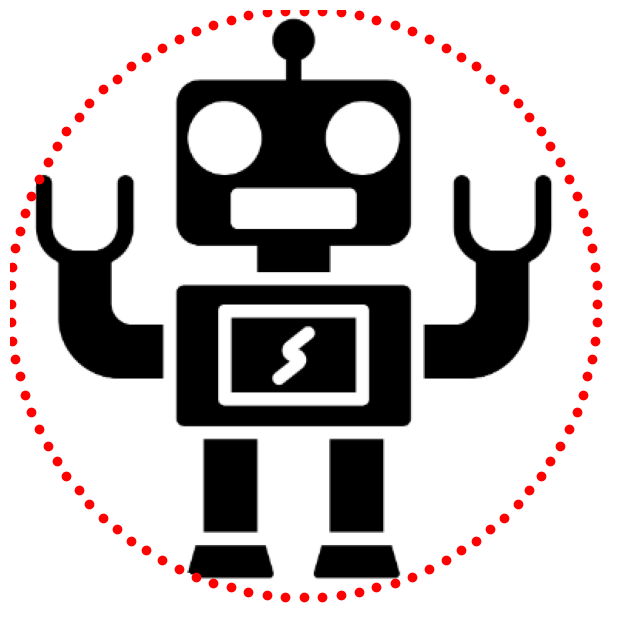

In [62]:
# Preprocess image
img, center, radius = preprocess_image("robot.png")

# Create anchors
n_anchors = 100
anchors = create_anchors(center, radius, n_anchors)

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray_r')
plt.scatter(anchors[:, 0], anchors[:, 1], color='red')
plt.axis('off')
plt.show()

In [47]:
def bresenham_line(x0, y0, x1, y1):
    """Generates the points of a line using Bresenham's line algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy        
    points.append((x, y))
    return points

In [48]:
def get_neighbors(x, y):
    """Get the four adjacent neighbors of a pixel."""
    return [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

In [49]:
def is_in_bounds(x, y, width, height):
    """Check if a pixel is within the image boundaries."""
    return 0 <= x < width and 0 <= y < height

In [50]:
def is_in_circle(x, y, center, radius):
    """Check if a pixel is within the circle."""
    return (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2

In [51]:
def calculate_darkness(distance, initial_darkness, slope=-0.06):
    """Calculate the darkness of a pixel based on its distance from the middle.
    
    The darkness is a linear function of the initial darkness, decreasing with increasing distance.
    The rate of decrease is determined by the slope (negative for decrease).
    """
    darkness = initial_darkness + slope * distance
    # Ensure darkness is within valid range
    darkness = max(0, min(1, darkness))
    return round(darkness, 2)

In [53]:
def draw_line(anchor1, anchor2, center, radius, darkness_list, img_dim):
    x0, y0 = (anchor1 * img_dim).astype(int)
    x1, y1 = (anchor2 * img_dim).astype(int)
    center = (center * img_dim).astype(int)
    radius = radius * img_dim

    # Create a sparse matrix to represent the image
    img_sparse = dok_matrix((img_dim, img_dim), dtype=np.float64)
    
    # Define a pixel dictionary
    pixel_dict = {darkness: [] for darkness in darkness_list}
    
    # Generate line pixels using Bresenham's line algorithm
    line_pixels = bresenham_line(x0, y0, x1, y1)
    
    # Add the pixels to the sparse matrix and pixel dictionary
    for pixel in line_pixels:
        if is_in_circle(pixel[0], pixel[1], center, radius):
            distance = np.sqrt((pixel[0] - center[0]) ** 2 + (pixel[1] - center[1]) ** 2)
            darkness = calculate_darkness(distance, darkness_list[0])
            img_sparse[pixel] = darkness
            pixel_dict[darkness].append(pixel)

    # Go through the dictionary and add neighbor pixels to the sparse matrix
    for index, darkness in enumerate(darkness_list):
        if index > 0:
            for i, v in enumerate(pixel_dict[darkness_list[index-1]]):
                neighbors = get_neighbors(*v)
                for neighbor in neighbors:
                    if neighbor not in pixel_dict[darkness_list[index-1]]:
                        if is_in_circle(neighbor[0], neighbor[1], center, radius):
                            distance = np.sqrt((neighbor[0] - center[0]) ** 2 + (neighbor[1] - center[1]) ** 2)
                            darkness = calculate_darkness(distance, darkness)
                            img_sparse[neighbor] = darkness
                            pixel_dict[darkness].append(neighbor)
    
    return img_sparse

In [34]:
# Get two anchors
anchor1, anchor2 = anchors[0], anchors[30]

# Get the image dimensions
height, width = img.shape

# Get the line pixels
pixel_dict = draw_line(anchor1, anchor2, center, radius)
pixel_dict

466
[(1350, 675), (1349, 676), (1348, 676), (1347, 677), (1346, 678), (1345, 679), (1344, 679), (1343, 680), (1342, 681), (1341, 682), (1340, 682), (1339, 683), (1338, 684), (1337, 684), (1336, 685), (1335, 686), (1334, 687), (1333, 687), (1332, 688), (1331, 689), (1330, 690), (1329, 690), (1328, 691), (1327, 692), (1326, 692), (1325, 693), (1324, 694), (1323, 695), (1322, 695), (1321, 696), (1320, 697), (1319, 698), (1318, 698), (1317, 699), (1316, 700), (1315, 700), (1314, 701), (1313, 702), (1312, 703), (1311, 703), (1310, 704), (1309, 705), (1308, 706), (1307, 706), (1306, 707), (1305, 708), (1304, 708), (1303, 709), (1302, 710), (1301, 711), (1300, 711), (1299, 712), (1298, 713), (1297, 713), (1296, 714), (1295, 715), (1294, 716), (1293, 716), (1292, 717), (1291, 718), (1290, 719), (1289, 719), (1288, 720), (1287, 721), (1286, 721), (1285, 722), (1284, 723), (1283, 724), (1282, 724), (1281, 725), (1280, 726), (1279, 727), (1278, 727), (1277, 728), (1276, 729), (1275, 729), (1274, 

<1352x1352 sparse matrix of type '<class 'numpy.float32'>'
	with 2651 stored elements in Dictionary Of Keys format>

In [12]:
"""# Get two anchors
anchor1, anchor2 = anchors[0], anchors[30]

# Get the image dimensions
height, width = img.shape

# Get the line pixels
pixel_dict = draw_line(anchor1, anchor2, width, height)
pixel_dict"""

'# Get two anchors\nanchor1, anchor2 = anchors[0], anchors[30]\n\n# Get the image dimensions\nheight, width = img.shape\n\n# Get the line pixels\npixel_dict = draw_line(anchor1, anchor2, width, height)\npixel_dict'

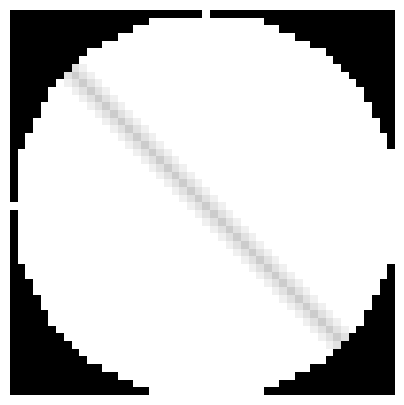

In [13]:
# Create a white circular canvas
canvas_size = 50
canvas = np.ones((canvas_size, canvas_size))
canvas_center = (canvas_size // 2, canvas_size // 2)
canvas_radius = canvas_size // 2
canvas_mask = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
cv2.circle(canvas_mask, canvas_center, canvas_radius, 1, thickness=-1)
canvas = np.multiply(canvas, canvas_mask)

# Draw a line from one corner to another
anchor1 = (0, 0)
anchor2 = (canvas_size - 1, canvas_size - 1)
pixel_dict = draw_line(anchor1, anchor2, canvas_center, canvas_radius)

# Apply the darkness values to the canvas
for pixel, value in pixel_dict.items():
    canvas[pixel[1], pixel[0]] = 1 - value

# Plot the canvas
plt.figure(figsize=(5, 5))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.show()

In [14]:
# Initialize the dictionary
anchor_lines = {}

# Get the first anchor
anchor1 = tuple(anchors[0])

# Start the timer
start = time.time()

# Iterate over the rest of the anchors
for anchor2 in anchors[1:]:
    # Convert anchor2 to a tuple
    anchor2 = tuple(anchor2)
    # Generate the line and save it to the dictionary
    anchor_lines[(anchor1, anchor2)] = draw_line(anchor1, anchor2, center, radius)

# Stop the timer
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
elapsed_time

0.4324979782104492

In [15]:
def generate_all_lines(anchors, center, radius):
    num_anchors = len(anchors)
    all_lines = {}

    # Iterate over all unique pairs of anchors
    for i in range(num_anchors):
        for j in range(i+1, num_anchors):
            anchor1 = tuple(anchors[i])
            anchor2 = tuple(anchors[j])
            all_lines[(anchor1, anchor2)] = draw_line(anchor1, anchor2, center, radius)
            
    return all_lines

In [16]:
# Start the timer
start = time.time()

# Generate all lines
all_lines = generate_all_lines(anchors, center, radius)

# Stop the timer
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
elapsed_time, len(all_lines)

(19.777500867843628, 4950)

In [17]:
def difference_value(pixel1, pixel2):
    """Calculate the absolute difference between two pixel values."""
    return abs(pixel1 - pixel2)

In [18]:
def create_difference_dict(image, center, radius):
    height, width = image.shape
    string_art_dict = {}

    for y in range(height):
        for x in range(width):
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2:
                # The canvas pixel value is 0 (white)
                string_art_dict[(x, y)] = difference_value(0, image[y, x])
                
    return string_art_dict

In [19]:
def create_string_art_dict(image, center, radius):
    height, width = image.shape
    string_art_dict = {}

    for y in range(height):
        for x in range(width):
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2:
                # The canvas pixel value is 0 (white)
                string_art_dict[(x, y)] = 0
                
    return string_art_dict

In [20]:
# Create the string art dictionary
difference_dict = create_difference_dict(img, center, radius)
string_art_dict = create_string_art_dict(img, center, radius)

In [21]:
def find_line_loss(line: dict):
    difference_dict_temp = difference_dict.copy()
    for pixel, value in line.items():
        new_value = min(1, string_art_dict[pixel] + value)
        difference_dict_temp[pixel] = difference_value(img[pixel[1], pixel[0]], new_value)
    loss = sum(difference_dict_temp.values())
    return loss

In [22]:
def find_best_line(anchor):
    best_loss = np.inf
    best_line = None
    for end_anchor in anchors:
        if not np.array_equal(anchor, end_anchor):
            # Construct the two possible keys
            key1 = ((anchor[0], anchor[1]), (end_anchor[0], end_anchor[1]))
            key2 = ((end_anchor[0], end_anchor[1]), (anchor[0], anchor[1]))
            key: tuple
            
            # Return the key if it exists in all_lines
            if key1 in all_lines:
                key = key1
            elif key2 in all_lines:
                key = key2
            
            loss = find_line_loss(all_lines[key])
            if(loss < best_loss):
                best_loss = loss
                best_line = key
                #print(best_loss)
                #print(best_line)
    #Copy new string to image
    for pixel, value in all_lines[best_line].items():
        new_value = min(1, string_art_dict[pixel] + value)
        string_art_dict[pixel] = new_value
        difference_dict[pixel] = difference_value(img[pixel[1], pixel[0]], new_value)
    
    if(anchor[0] == best_line[0][0]):
        return best_line[1]
    else:
        return best_line[0]

In [23]:
#test = find_best_line(anchors[34])
#print(test)

In [24]:
def create_string_art(iterations: int, starting_anchor):
    current_anchor = starting_anchor
    while iterations > 0:
        iterations -= 1
        current_anchor = find_best_line(current_anchor)

In [26]:
create_string_art(10, anchors[0])

1.0


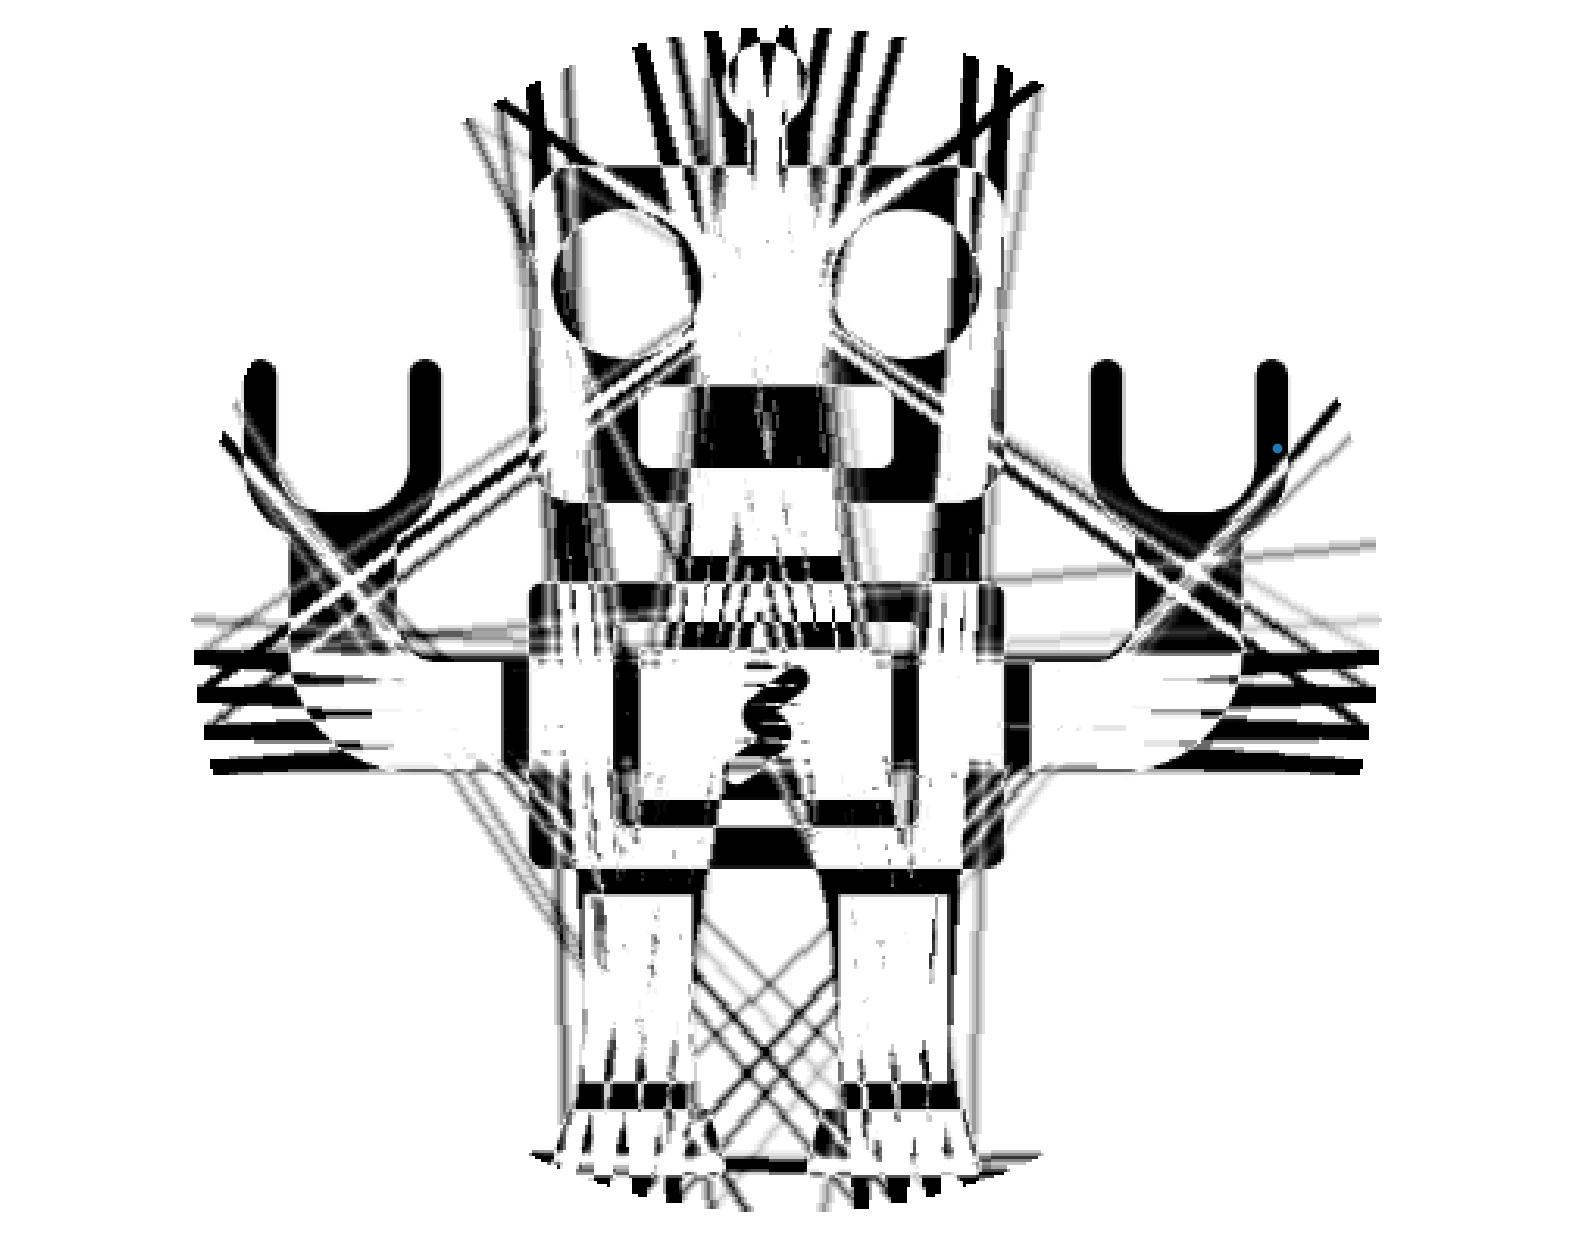

In [ ]:
# Create a blank white canvas
canvas = np.ones((height, width))

# Draw the circle using the string_art_dict
for (x, y), value in difference_dict.items():
    canvas[y, x] = 1 - value  # subtract from 1 because 1 is white and 0 is black
print(difference_dict[405,140])

# Show the canvas
plt.figure(figsize=(20, 20))
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.scatter(405, 140)
plt.axis('off')
plt.show()

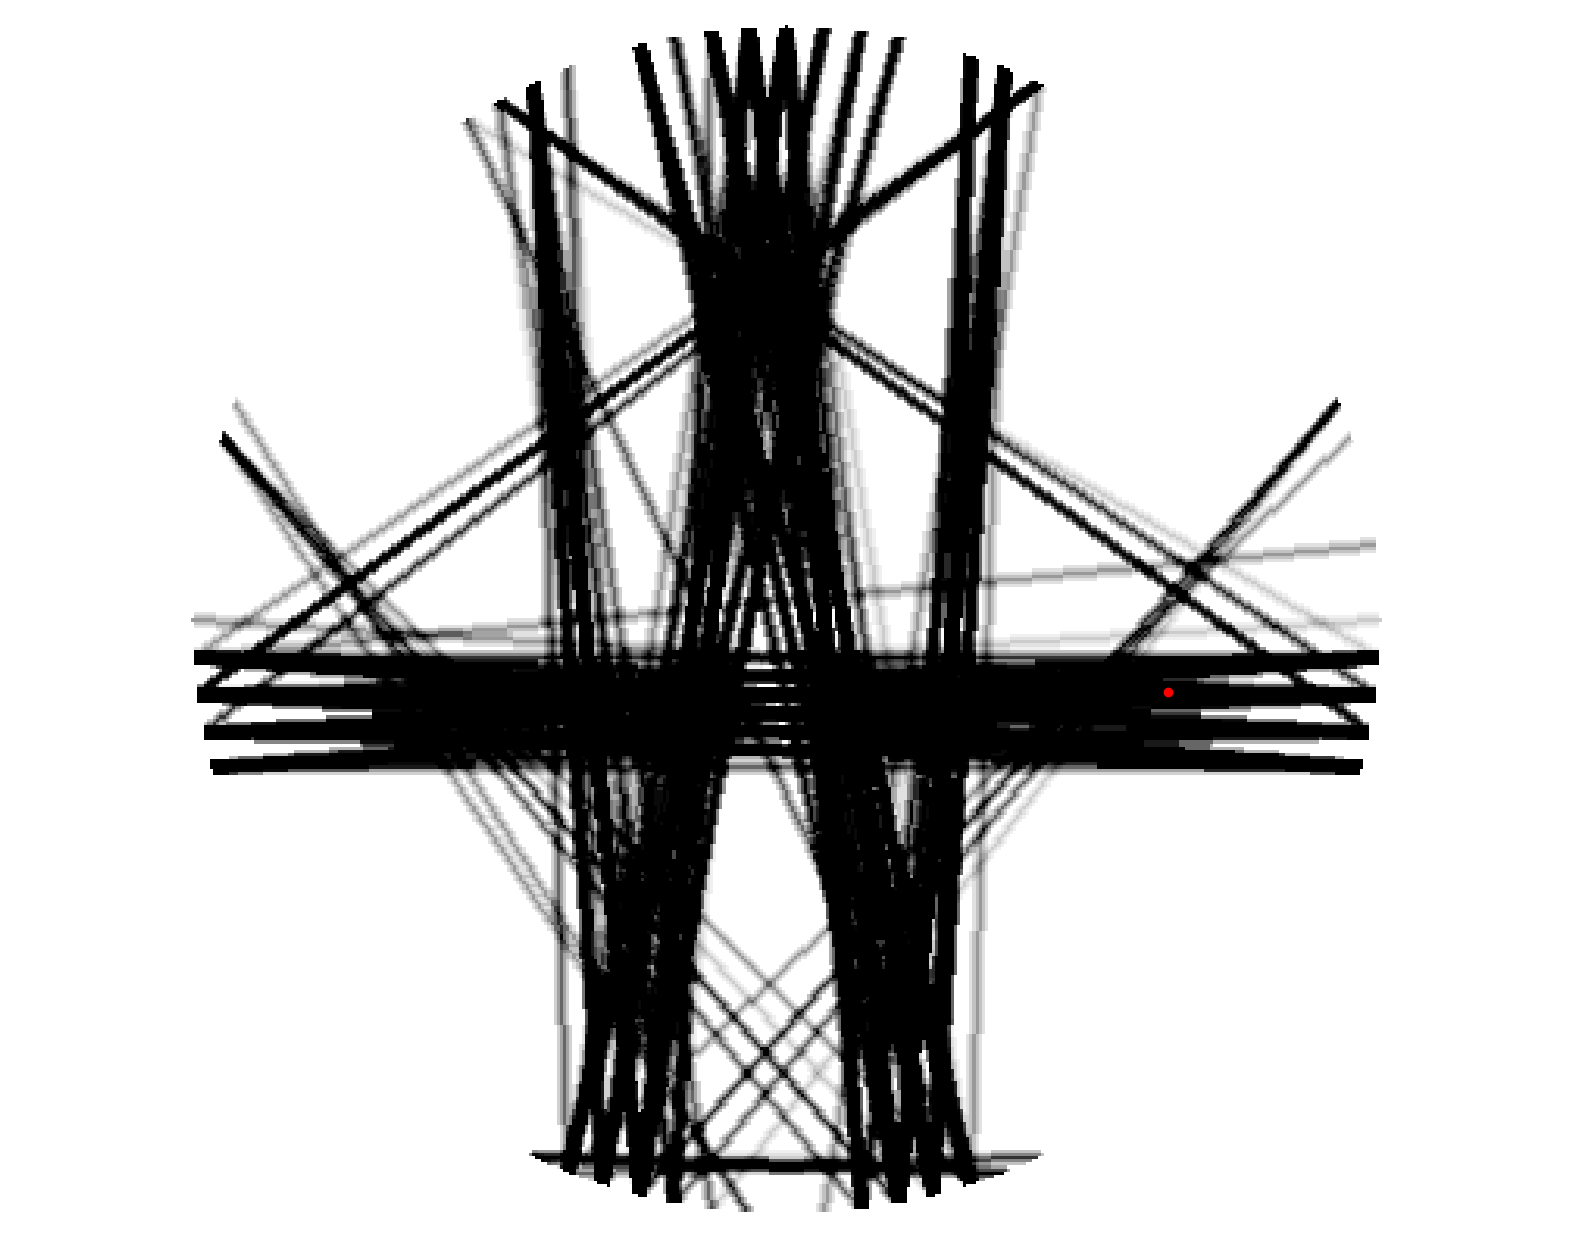

In [ ]:
# Create a blank white canvas
canvas = np.ones((height, width))

# Draw the circle using the string_art_dict
for (x, y), value in string_art_dict.items():
    canvas[y, x] = 1 - value  # subtract from 1 because 1 is white and 0 is black

# Show the canvas
plt.figure(figsize=(20, 20))
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.scatter(370, 218, color='red')  # Specify color for the scatter points
plt.axis('off')
plt.show()